#AI VIET NAM
#Transformer-Encoder

#**1. Transformer-Encoder**

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(42)

###**1.1. Scaled Dot-Product Attention**

In [ ]:
query = torch.randint(
    high=2,
    size=(1, 4, 4), # batch_size x seq_len x embedding_dim
    dtype=torch.float32
)
query

tensor([[[0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.]]])

In [ ]:
key = torch.randint(
    high=2,
    size=(1, 4, 4),
    dtype=torch.float32
)
key

tensor([[[1., 1., 1., 0.],
         [1., 0., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 0., 0.]]])

In [ ]:
value = key
value

tensor([[[1., 1., 1., 0.],
         [1., 0., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 0., 0.]]])

In [ ]:
attentionn_weight = F.scaled_dot_product_attention(
    query=query,
    key=key,
    value=value
)
attentionn_weight

tensor([[[1.0000, 0.8318, 0.7227, 0.4455],
         [1.0000, 0.8318, 0.7227, 0.4455],
         [1.0000, 0.8318, 0.7227, 0.4455],
         [1.0000, 0.7227, 0.8318, 0.5545]]])

###**1.2. Self-Attention**

In [ ]:
input = torch.randint(
    high=2,
    size=(1, 3, 3),
    dtype=torch.float32
)
input

tensor([[[1., 1., 1.],
         [0., 1., 0.],
         [0., 0., 0.]]])

In [ ]:
attentionn_weight = F.scaled_dot_product_attention(input, input, input)
attentionn_weight

tensor([[[0.6702, 0.8814, 0.6702],
         [0.3904, 0.7808, 0.3904],
         [0.3333, 0.6667, 0.3333]]])

###**1.3. Multi-Head Attention**

In [ ]:
batch_size = 1
seq_len = 50
embedding_dim = 200

input = torch.randint(
    high=2,
    size=(batch_size, seq_len, embedding_dim),
    dtype=torch.float32
)
input

tensor([[[0., 1., 1.,  ..., 0., 1., 1.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [1., 0., 1.,  ..., 0., 1., 1.],
         [0., 1., 1.,  ..., 1., 1., 1.]]])

In [ ]:
embedding_dim = 200
num_heads = 5

att_layer = nn.MultiheadAttention(
    embed_dim=embedding_dim,
    num_heads=num_heads,
    batch_first=True
)

In [ ]:
attn_output, attn_output_weights = att_layer(
    query=input,
    key=input,
    value=input
)

In [ ]:
attn_output.shape

torch.Size([1, 50, 200])

In [ ]:
attn_output_weights.shape

torch.Size([1, 50, 50])

###**1.4. Transformer-Encoder**

####**Token and Positional Embedding**

In [ ]:
class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_length, device='cpu'):
        super().__init__()
        self.device = device
        self.word_emb = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim
        )
        self.pos_emb = nn.Embedding(
            num_embeddings=max_length,
            embedding_dim=embed_dim
        )

    def forward(self, x):
        N, seq_len = x.size()
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        output1 = self.word_emb(x)
        output2 = self.pos_emb(positions)
        output = output1 + output2
        return output

In [ ]:
vocab_size = 10000
embed_dim = 200
max_length = 50
embedding = TokenAndPositionEmbedding(
    vocab_size,
    embed_dim,
    max_length
)

In [ ]:
batch_size = 32

input = torch.randint(
    high=2,
    size=(batch_size, max_length),
    dtype=torch.int64
)

In [ ]:
embedded = embedding(input)

In [ ]:
embedded.shape

torch.Size([32, 50, 200])

####**Transformer-Encoder Layer**

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        attn_output, _ = self.attn(query, key, value)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(query + attn_output)
        ffn_output = self.ffn(out_1)
        ffn_output = self.dropout_2(ffn_output)
        out_2 = self.layernorm_2(out_1 + ffn_output)
        return out_2

In [ ]:
encoder_layer = TransformerEncoder(
    embed_dim=200,
    num_heads=5,
    ff_dim=1024
)

In [ ]:
embedded.shape

torch.Size([32, 50, 200])

In [ ]:
encoded = encoder_layer(embedded, embedded, embedded)

In [ ]:
encoded.shape

torch.Size([32, 50, 200])

#**2. Text Classification using Transformer-Encoder**

###**2.1. Load Dataset**

In [ ]:
!git clone https://github.com/congnghia0609/ntc-scv.git

Cloning into 'ntc-scv'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 39 (delta 0), reused 4 (delta 0), pack-reused 35
Receiving objects: 100% (39/39), 186.94 MiB | 27.75 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (11/11), done.


In [ ]:
!unzip ./ntc-scv/data/data_test.zip -d ./data
!unzip ./ntc-scv/data/data_train.zip -d ./data
!rm -rf ./ntc-scv

Streaming output truncated to the last 5000 lines.
  inflating: ./data/data_train/train/pos/31228.txt  
  inflating: ./data/data_train/train/pos/3123.txt  
  inflating: ./data/data_train/train/pos/31232.txt  
  inflating: ./data/data_train/train/pos/31233.txt  
  inflating: ./data/data_train/train/pos/31234.txt  
  inflating: ./data/data_train/train/pos/31236.txt  
  inflating: ./data/data_train/train/pos/31238.txt  
  inflating: ./data/data_train/train/pos/31240.txt  
  inflating: ./data/data_train/train/pos/31242.txt  
  inflating: ./data/data_train/train/pos/31247.txt  
  inflating: ./data/data_train/train/pos/31250.txt  
  inflating: ./data/data_train/train/pos/31251.txt  
  inflating: ./data/data_train/train/pos/31252.txt  
  inflating: ./data/data_train/train/pos/31257.txt  
  inflating: ./data/data_train/train/pos/31260.txt  
  inflating: ./data/data_train/train/pos/31261.txt  
  inflating: ./data/data_train/train/pos/31262.txt  
  inflating: ./data/data_train/train/pos/31273.tx

In [ ]:
import os
import pandas as pd

def load_data_from_path(folder_path):
    examples = []
    for label in os.listdir(folder_path):
        full_path = os.path.join(folder_path, label)
        for file_name in os.listdir(full_path):
            file_path = os.path.join(full_path, file_name)
            with open(file_path, "r", encoding="utf-8") as f:
                lines = f.readlines()
            sentence = " ".join(lines)
            if label == "neg":
                label = 0
            if label == "pos":
                label = 1
            data = {
                'sentence': sentence,
                'label': label
            }
            examples.append(data)
    return pd.DataFrame(examples)

In [ ]:
folder_paths = {
    'train': './data/data_train/train',
    'valid': './data/data_train/test',
    'test': './data/data_test/test'
}

train_df = load_data_from_path(folder_paths['train'])
valid_df = load_data_from_path(folder_paths['valid'])
test_df = load_data_from_path(folder_paths['test'])

###**2.2. Preprocessing**

**Text Cleaning**

In [ ]:
import re
import string

def preprocess_text(text):
    # remove URLs https://www.
    url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
    text = url_pattern.sub(r" ", text)

    # remove HTML Tags: <>
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    # remove puncs and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    # remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    # normalize whitespace
    text = " ".join(text.split())

    # lowercasing
    text = text.lower()
    return text

In [ ]:
train_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df.iterrows()]
valid_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in valid_df.iterrows()]
test_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in test_df.iterrows()]

###**2.3. Representation**

In [ ]:
!pip install -q torchtext==0.16.0

In [ ]:
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

In [ ]:
# word-based tokenizer
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

In [ ]:
# build vocabulary
from torchtext.vocab import build_vocab_from_iterator

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(train_df['preprocess_sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=["<pad>", "<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

In [ ]:
from torchtext.data.functional import to_map_style_dataset

def prepare_dataset(df):
    # create iterator for dataset: (sentence, label)
    for index, row in df.iterrows():
        sentence = row['preprocess_sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label

train_dataset = prepare_dataset(train_df)
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(valid_df)
valid_dataset = to_map_style_dataset(valid_dataset)

test_dataset = prepare_dataset(test_df)
test_dataset = to_map_style_dataset(test_dataset)

###**2.4. Dataloader**

In [ ]:
import torch

seq_length = 100

def collate_batch(batch):
    # create inputs, offsets, labels for batch
    sentences, labels = list(zip(*batch))
    encoded_sentences = [
        sentence+([0]* (seq_length-len(sentence))) if len(sentence) < seq_length else sentence[:seq_length]
        for sentence in sentences
    ]

    encoded_sentences = torch.tensor(encoded_sentences, dtype=torch.int64)
    labels = torch.tensor(labels)

    return encoded_sentences, labels

In [ ]:
from torch.utils.data import DataLoader

batch_size = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [ ]:
next(iter(train_dataloader))

(tensor([[  41,  108,  299,  ...,    0,    0,    0],
         [ 119,   92, 2628,  ...,   55,  801, 2857],
         [ 102,  111,  314,  ...,  127, 1538,   17],
         ...,
         [ 677,  148,   39,  ...,    0,    0,    0],
         [  91,   92,   20,  ...,    0,    0,    0],
         [   3,    9,   34,  ...,   81,  475,  354]]),
 tensor([0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
         0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 1, 1, 1, 0]))

In [ ]:
len(train_dataloader)

235

In [ ]:
encoded_sentences, labels = next(iter(train_dataloader))

In [ ]:
encoded_sentences.shape

torch.Size([128, 100])

In [ ]:
labels.shape

torch.Size([128])

###**2.5. Trainer**

In [ ]:
import time

def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [ ]:
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [ ]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        # Training
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Evaluation
        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)
        # Print loss, acc end epoch
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
            )
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'train_accuracy': train_accs,
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

In [ ]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

###**2.6. Modeling**

In [ ]:
class TransformerEncoderCls(nn.Module):
    def __init__(self,
                 vocab_size, max_length, embed_dim, num_heads, ff_dim,
                 dropout=0.1, device='cpu'
        ):
        super().__init__()
        self.embd_layer = TokenAndPositionEmbedding(
            vocab_size, embed_dim, max_length, device
        )
        self.transformer_layer = TransformerEncoder(
            embed_dim, num_heads, ff_dim, dropout
        )
        self.pooling = nn.AvgPool1d(kernel_size=max_length)
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=2)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
    def forward(self, x):
        output = self.embd_layer(x)
        output = self.transformer_layer(output, output, output)
        output = self.pooling(output.permute(0,2,1)).squeeze()
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output

In [ ]:
vocab_size = 10000
max_length = 100
embed_dim = 200
num_heads = 4
ff_dim = 128
dropout=0.1
model = TransformerEncoderCls(
    vocab_size, max_length, embed_dim, num_heads, ff_dim, dropout
)

In [ ]:
encoded_sentences.shape

torch.Size([128, 100])

In [ ]:
predictions = model(encoded_sentences)

In [ ]:
predictions.shape

torch.Size([128, 2])

###**2.7. Training**

In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TransformerEncoderCls(
    vocab_size, max_length, embed_dim, num_heads, ff_dim, dropout, device
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

num_epochs = 50
save_model = './model'
os.makedirs(save_model, exist_ok = True)
model_name = 'model'

model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device
)

| epoch   1 |    50/  235 batches | accuracy    0.518
| epoch   1 |   100/  235 batches | accuracy    0.565
| epoch   1 |   150/  235 batches | accuracy    0.637
| epoch   1 |   200/  235 batches | accuracy    0.673
-----------------------------------------------------------
| End of epoch   1 | Time:  7.37s | Train Accuracy    0.690 | Train Loss    0.660 | Valid Accuracy    0.700 | Valid Loss    0.604 
-----------------------------------------------------------
| epoch   2 |    50/  235 batches | accuracy    0.704
| epoch   2 |   100/  235 batches | accuracy    0.723
| epoch   2 |   150/  235 batches | accuracy    0.737
| epoch   2 |   200/  235 batches | accuracy    0.745
-----------------------------------------------------------
| End of epoch   2 | Time:  4.07s | Train Accuracy    0.754 | Train Loss    0.564 | Valid Accuracy    0.761 | Valid Loss    0.511 
-----------------------------------------------------------
| epoch   3 |    50/  235 batches | accuracy    0.763
| epoch   3 

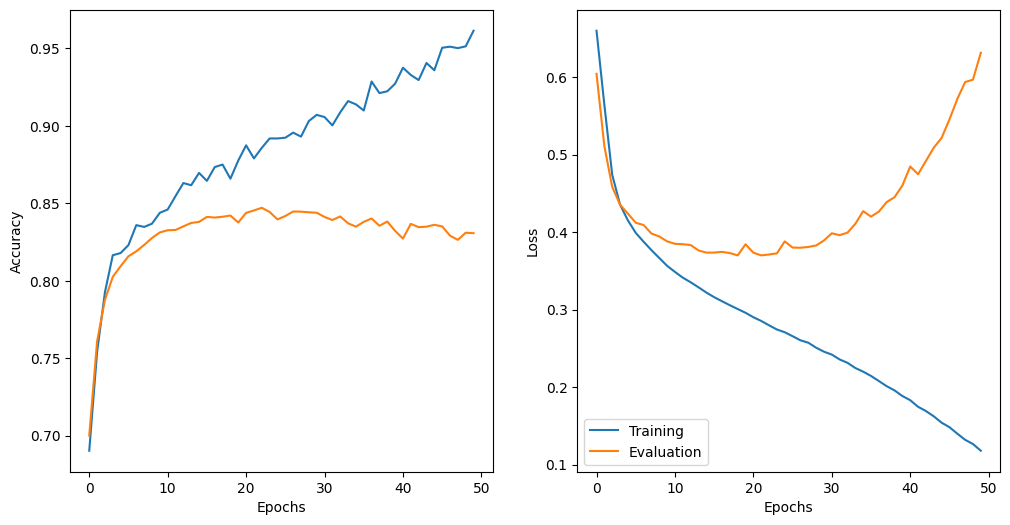

In [ ]:
plot_result(
    num_epochs,
    metrics["train_accuracy"],
    metrics["valid_accuracy"],
    metrics["train_loss"],
    metrics["valid_loss"]
)

In [ ]:
test_acc, test_loss = evaluate_epoch(model, criterion, test_dataloader, device)
test_acc, test_loss

(0.8413, 0.5712443518487713)

# **3. Vision Transformer**

### **3.1. Patch Embedding**

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim=512, patch_size=16, image_size=224):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)

    def forward(self, x):
        x = self.conv1(x) # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
        return x

In [ ]:
patch_embedding = PatchEmbedding()
x = torch.randn(1, 3, 224, 224)

out = patch_embedding(x)
print(out.shape)

torch.Size([1, 196, 512])


### **3.2. Positional Embedding**

In [ ]:
class PatchPositionEmbedding(nn.Module):
    def __init__(self, image_size=224, embed_dim=512, patch_size=16, device='cpu'):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        scale = embed_dim ** -0.5
        self.positional_embedding = nn.Parameter(scale * torch.randn((image_size // patch_size) ** 2, embed_dim))
        self.device = device

    def forward(self, x):
        x = self.conv1(x) # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]

        x = x + self.positional_embedding.to(self.device)
        return x

In [ ]:
patchpos_embedding = PatchPositionEmbedding()
x = torch.randn(1, 3, 224, 224)

out = patchpos_embedding(x)
print(out.shape)

torch.Size([1, 196, 512])


### **3.3. Adding [CLS] token**

In [ ]:
class PatchPositionEmbedding(nn.Module):
    def __init__(self, embed_dim=512, patch_size=16, image_size=224):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)

        scale = embed_dim ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(embed_dim))
        self.positional_embedding = nn.Parameter(scale * torch.randn((image_size // patch_size) ** 2 + 1, embed_dim))

    def forward(self, x):
        x = self.conv1(x) # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
        # expanding the CLS embedding
        cls_embs = self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device)
        x = torch.cat([cls_embs, x], dim=1)  # shape = [*, grid ** 2 + 1, width]

        x = x + self.positional_embedding.to(x.dtype)
        return x

In [ ]:
patchpos_embedding = PatchPositionEmbedding()
x = torch.randn(1, 3, 224, 224)

out = patchpos_embedding(x)
print(out.shape)

torch.Size([1, 197, 512])


In [ ]:
class VisionTransformerCls(nn.Module):
    def __init__(self,
                 image_size, embed_dim, num_heads, ff_dim,
                 dropout=0.1, device='cpu', num_classes = 10, patch_size=16
        ):
        super().__init__()
        self.embd_layer = PatchPositionEmbedding(
            image_size=image_size, embed_dim=embed_dim, patch_size=patch_size
        )
        self.transformer_layer = TransformerEncoder(
            embed_dim, num_heads, ff_dim, dropout
        )
        # self.pooling = nn.AvgPool1d(kernel_size=max_length)
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=num_classes)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
    def forward(self, x):
        output = self.embd_layer(x)
        output = self.transformer_layer(output, output, output)
        output = output[:, 0, :]
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output

In [ ]:
image_size=224
embed_dim = 512
num_heads = 4
ff_dim = 128
dropout=0.1

vit = VisionTransformerCls(image_size=224, embed_dim=512, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)

In [ ]:
x = torch.randn(1, 3, 224, 224)
out = vit(x)
print(out.shape)

torch.Size([1, 10])


### **3.5. Load Data**

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:01<00:00, 90919032.56it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### **3.4. Training**

In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VisionTransformerCls(
    image_size=224, embed_dim=512, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, num_classes=10
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

num_epochs = 50
save_model = './model'
os.makedirs(save_model, exist_ok = True)
model_name = 'model'

model, metrics = train(
    model, model_name, save_model, optimizer, criterion, trainloader, testloader, num_epochs, device
)

Streaming output truncated to the last 5000 lines.
| epoch  31 |  2050/12500 batches | accuracy    0.600
| epoch  31 |  2100/12500 batches | accuracy    0.610
| epoch  31 |  2150/12500 batches | accuracy    0.540
| epoch  31 |  2200/12500 batches | accuracy    0.530
| epoch  31 |  2250/12500 batches | accuracy    0.545
| epoch  31 |  2300/12500 batches | accuracy    0.630
| epoch  31 |  2350/12500 batches | accuracy    0.515
| epoch  31 |  2400/12500 batches | accuracy    0.630
| epoch  31 |  2450/12500 batches | accuracy    0.565
| epoch  31 |  2500/12500 batches | accuracy    0.545
| epoch  31 |  2550/12500 batches | accuracy    0.550
| epoch  31 |  2600/12500 batches | accuracy    0.585
| epoch  31 |  2650/12500 batches | accuracy    0.630
| epoch  31 |  2700/12500 batches | accuracy    0.610
| epoch  31 |  2750/12500 batches | accuracy    0.545
| epoch  31 |  2800/12500 batches | accuracy    0.560
| epoch  31 |  2850/12500 batches | accuracy    0.595
| epoch  31 |  2900/12500 batch

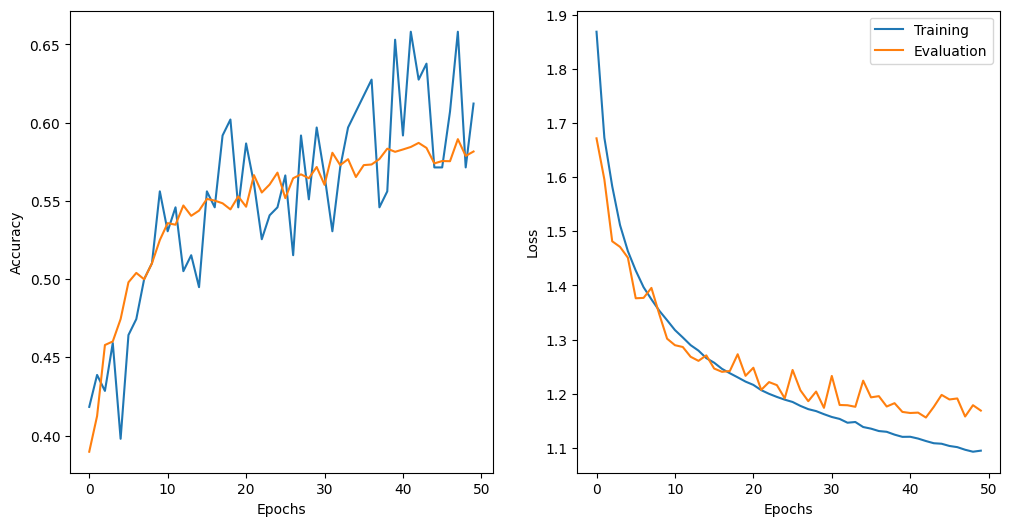

In [ ]:
plot_result(
    num_epochs,
    metrics["train_accuracy"],
    metrics["valid_accuracy"],
    metrics["train_loss"],
    metrics["valid_loss"]
)